In [14]:
from imutils.object_detection import non_max_suppression
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import imutils
import numpy as np
import requests
import pytesseract
import cv2
import pandas as pd


In [6]:
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

In [11]:
# 이미지를 확인하기 위한 함수
def plt_imshow(title='image', img=None, figsize=(8,5)):
    plt.figure(figsize=figsize)
    
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles=[]
            
            for i in range(len(img)):
                titles.append(title)
                
        for i in range(len(img)):
            if len(img[i].shape)<2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2BGR)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
                
            plt.subplot(1, len(img), i+1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
        plt.show()
        
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [26]:
# 추출된 결과를 가공하는 함수
def decode_predictions(scores, geometry):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    
    for y in range(0, numRows):
        scoresData = scores[0,0,y]
        xData0 = geometry[0,0,y]
        xData1 = geometry[0,1,y]
        xData2 = geometry[0,2,y]
        xData3 = geometry[0,3,y]
        anglesData = geometry[0,4,y]
        
        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue
            
            (offsetX, offsetY) = (x*4.0, y*4.0)
            
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[[x]]))
            
            startX = int(endX - w)
            startY = int(endY - h)
            
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
    return (rects, confidences)

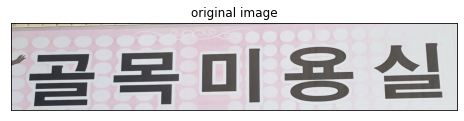

In [13]:
img_path = '../train/train_00001.png'

org_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
plt_imshow('original image', org_img)

In [ ]:
# find contours
image = org_img.copy()
image = imutils.resige(image, width=500)
ratio = org_img.shape[1] / float(image.shape[1])

# 이미지를 grayscale로 변환하고 blur 적용
# 모서리를 찾기 위한 이미지 연산

In [25]:
# Load Model
layerNames = ['feature_fusion/COnv_7/Sigmoid', 'feature_fusion/concat_3']

# 사전에 훈련된 EAST text detector 모델 load
print('[INFO] loading EAST dector...')
net = cv2.dnn.readNet("../model//frozen_east_text_detection.pb")

[INFO] loading EAST dector...


In [27]:
width = 640
height = 640
min_confidence = 0.5
padding = 0.0

In [28]:
# image resize 
orig = org_img.copy()
(orgH, orgW) = org_img.shape[:2]

(newH, newW) = (width, height)
rW = orgW / float(newW)
rH = orgH / float(newH)

org_img = cv2.resize(org_img, (newW, newH))
(H, W) = org_img.shape[:2]

In [35]:
# Text Detection

blob = cv2.dnn.blobFromImage(org_img, 1.0, (W, H), (123.68, 116.78, 103.94),
                             swapRB = True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward()

(rects, confidence) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidence)

ValueError: not enough values to unpack (expected 2, got 1)